# Identify mismatched barcodes

In [33]:
from datetime import date
print('created 2024-04-24')
print("last updated", date.today())

created 2024-04-24
last updated 2025-01-23


In [34]:
# imports

import sys
import time
import pickle
import random
#import pysam
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

import warnings
warnings.filterwarnings(action='once')

# aesthetics
plt.rcParams['figure.dpi']= 200
sns.set_palette("husl", 5)

def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'

# b2i dict from nanopore 0.6 clustering and with spike-in barcodes
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters.pkl', 'rb') as f:
    b2i = pickle.load(f)

# explore list of all extracted barcodes and introns (no filters)

goals: look through reads to see which barcodes are mismatched in a significant fraction of their appearances

from each nanopore read:
- get dtom barcode
- get gfp barcode
- filter to reads where both barcodes are in dictionary (perfectly or one-off)

now in this set, for each read:
- extract intron sequence for dTom barcode
- intron sequence for GFP barcode

now for each barcode ask:
- what fraction of reads with this barcode in dtom have a DIFFERENT INTRON for gfp barcode vs. SAME?
- what fraction of reads with this barcode in GFP have a DIFFERENT INTRON for dTom barcode vs. SAME?
- of the total reads of EITHER containing this barcode, what fraction are matched vs. mismatched?

rank by % mismatched, plot with barcodes on x %mm on y, log10 scale

In [3]:
# load in entire set of barcode-intron-barcode sets parsed from nanopore reads

# note full set takes a minute to load
raw = pd.read_csv(outpath+'data/raw_barcode_intron_table.csv')
#raw = pd.read_csv(RIL2_path+'raw_barcode_intron_table_1M_test_set.csv')

## parse reads and identify which mismatches should be considered to have the same intron vs different

In [4]:
# function to see if any one-offs of a barcode are in b2i
# would be ideal to check two-offs as well but computationally intensive

def check_one_offs_in_b2i(bc, b2i):
    ok_bc = None
    if bc in b2i:
        ok_bc = bc
    else:
        voos = [oo for oo in bc_one_offs(bc) if oo in b2i]
        if len(voos) == 1:    # if one one-off is in dict
            ok_bc = voos[0]    # change bc to that one off
        elif len(voos) > 1:    # if multiple one-offs in dict                 
            ints = len(set([b2i[v] for v in voos]))             
            if ints == 1:    # and all ints are same
                ok_bc = voos[0]    # keep
    return ok_bc

In [5]:
# filter to reads where barcodes have at least 2 nucleotides different
mismatch_pairs = [(x,y,d) for x,y,d in zip(raw.g_bc,raw.dt_bc,raw.bc_dists) if d>1]

len(mismatch_pairs)/len(raw)

0.37919967008103156

In [6]:
# how many barcodes are represented here?
len(set([x for x,y,d in mismatch_pairs]+[y for x,y,d in mismatch_pairs]))

4031179

In [7]:
# now we are only considering barcodes in b2i
# make list of barcode pairs and their distances

###    NOTE: TAKES A FEW MINUTES    ###

true_mm_pairs = []
for x,y,d in mismatch_pairs:
    new_x, new_y = check_one_offs_in_b2i(x, b2i), check_one_offs_in_b2i(y, b2i)
    if new_x is not None and new_y is not None:
        true_mm_pairs.append((new_x,new_y,d))

In [8]:
# now what are the distances between the INTRONS of these barcodes?
# and what fraction of mismatch pairs can be BOTH assigned to valid barcodes?

intdists = [(lev(b2i[x][12:-40], b2i[y][12:-40]),d) for x,y,d in true_mm_pairs]
len(intdists)/len(mismatch_pairs)

0.008805897402171976

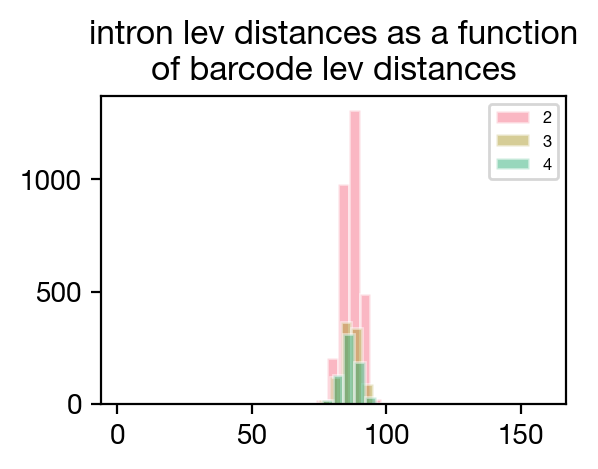

In [9]:
sns.set_palette("husl", 5)
plt.figure(figsize=(3,2))
for i in range(2,5):
    plt.hist([x for x,y in intdists if y==i], bins=range(i,160,4), label=i, edgecolor='white', alpha=0.5)
#plt.yscale('log')
plt.legend(fontsize=6)
plt.title('intron lev distances as a function\nof barcode lev distances')
plt.show()

# conclusions:
- 38% of reads have at least edit distance 2 between GFP/dTom barcodes
- 0.9% of those have 2 diff barcodes that can both be called as a valid dictionary barcode (lev 0 or 1)
- any edit distance between 2 barcodes in dictionary results in totally different introns; i.e., there are not many duplicate introns with multiple barcodes only separated by seq errors in dictionary

now for each barcode ask:

- what fraction of reads with this barcode in dtom have a DIFFERENT INTRON for gfp barcode vs. SAME?
- what fraction of reads with this barcode in GFP have a DIFFERENT INTRON for dTom barcode vs. SAME?
- of the total reads of EITHER containing this barcode, what fraction are matched vs. mismatched?
- rank by mismatched/matched, plot with barcodes on x %mm on y, log10 scale

## count mismatches and compute rates

In [10]:
# what are the edit distances btwn barcodes in a read
# for all reads that have 2 diff barcodes
# where at least 1 is in b2i?

bc_distance_counts = {bc:[] for bc in b2i.keys()}

for x,y,d in zip(raw.g_bc,raw.dt_bc,raw.bc_dists):
    if x in b2i:
        bc_distance_counts[x].append(d)
    if y in b2i and y!=x:
        bc_distance_counts[y].append(d)

if the barcodes are the same and separated by sequencing errors, we expect them to have edit distance distributed like the barcodes mapped to the same intron...

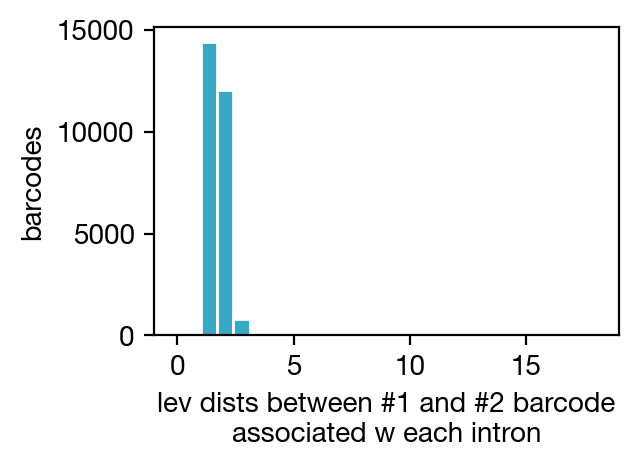

In [11]:
with open(outpath+'pkls/bc_dists_06_min3readclusters.pkl', 'rb') as f:
    bc_dists_06 = pickle.load(f)

plt.figure(figsize=(3,2))
plt.hist(bc_dists_06, 
         bins=17, 
         facecolor=nicecolors(3), edgecolor='w')
plt.ylabel('barcodes')
plt.xlabel('lev dists between #1 and #2 barcode\nassociated w each intron')
plt.xlim(-1,19)
plt.show()

whereas if they are truly different, we expect a distribution of edit distances centered around 2/3 of the barcode length, or 12. we can simulate this by selecting and comparing random barcodes with one another.

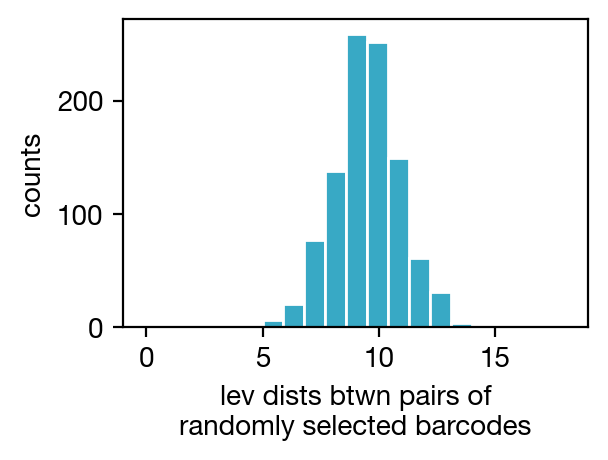

In [12]:
plt.figure(figsize=(3,2))
plt.hist([lev(a,b) for a,b in zip(list(b2i.keys())[:1000],list(b2i.keys())[1:2000])],
        #bins=18, 
         facecolor=nicecolors(3), edgecolor='w')
plt.ylabel('counts')
plt.xlabel('lev dists btwn pairs of\nrandomly selected barcodes')
plt.xlim(-1,19)
plt.show()

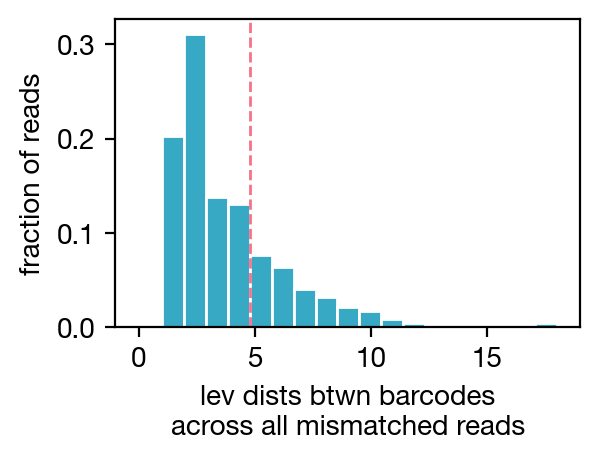

In [13]:
# now plot ACTUAL distribution of edit distances between paired barcodes
# and use to select cutoff for calling match/mismatch

import random
all_dists = (flatten(bc_distance_counts.values()))

plt.figure(figsize=(3,2))
plt.hist(random.sample([x for x in all_dists if x>0],100000), density=True,
        bins=18, facecolor=nicecolors(3), edgecolor='w')
plt.ylabel('fraction of reads')
plt.xlabel('lev dists btwn barcodes\nacross all mismatched reads')
plt.axvline(4.8, linewidth=1, linestyle='--')
plt.xlim(-1,19)
plt.show()

In [14]:
# based on this distribution I'm going to use max 4 errors as the cutoff for calling a barcode match
mm_threshold = 4

In [15]:
# examine barcodes with lev dist 2 - what is causing this?
# looks like indels

for x,y,d in list(zip(raw.g_bc,raw.dt_bc,raw.bc_dists))[:100]:
    if d==2:
        if (x in b2i)|(y in b2i):
            print(x)
            print(y)
            print()

TCTCCCCCCTATATCTTT
CTCTCCCCCTATATCTTT

CCCTTCCAAATCCACATA
ACCCTCCAAATCCACATA

CTTCCCATTCTCTTTTCA
ACTTCCCATTCTCTTTCA

-TTTTCACCACATACCTT
TTTTCACCACATACCTTT

CACATTATAAATCTACCC
ACATTATAAATCTACCCC

TCTTTCAAACCTTCACCA
TACTTCAAACCTTCACCA

-CCAAATAACCTCAATAA
CCAAATAACCTCAAATAA

ACACTCCCACTTATCAAA
-ACACTCCACTTATCAAA



In [16]:
# mismatch counting for all barcodes WITH matching one-offs
# (also takes a few minutes to run)

counts = ['match','GFP_mismatch','dTom_mismatch', 'GFP_mm_rate', 'dTom_mm_rate', 'global_mm_rate']
bc_mm_fractions = {bc:{c:0 for c in counts} for bc in b2i.keys()}

# go through at ALL READS!
# 1. if both barcodes are valid, check if they have same intron and increment matches/mismatches accordingly
# 2. if either barcode looks invalid check one-offs
# 3. if only one barcode is valid and d>threshold call it a mismatch

for x,y,d in zip(raw.g_bc,raw.dt_bc,raw.bc_dists):

    if x in b2i: 
        if d == 0:    # if the barcodes are identical then it counts as a match for that barcode
            bc_mm_fractions[x]['match'] += 1
        
        if y in b2i and d!=0:    # if the barcodes are valid but different check their introns
            int_dist = lev(b2i[x][12:-40], b2i[y][12:-40])
            
            if int_dist>40:    
                bc_mm_fractions[x]['GFP_mismatch'] += 1
                bc_mm_fractions[y]['dTom_mismatch'] += 1
                
            else:
                bc_mm_fractions[x]['match'] += 1
                bc_mm_fractions[y]['match'] += 1

        if y not in b2i:   
            new_y = check_one_offs_in_b2i(y,b2i)    # check one-offs
            if new_y is not None:
                int_dist = lev(b2i[x][12:-40], b2i[new_y][12:-40])
                if int_dist>40:    
                    bc_mm_fractions[x]['GFP_mismatch'] += 1
                    bc_mm_fractions[new_y]['dTom_mismatch'] += 1
                else:    # if their introns match then they each get a respective match
                    bc_mm_fractions[x]['match'] += 1
                    bc_mm_fractions[new_y]['match'] += 1
                
            # this is a little arbitrary but even if y is not a valid barcode, if it's sufficiently
            # different from x i think I should count it as a mismatch
            elif new_y is None and d>mm_threshold:   
                bc_mm_fractions[x]['GFP_mismatch'] += 1
                
    # what if x is not a valid barcode but y is?
    elif x not in b2i and y in b2i: 
        new_x = check_one_offs_in_b2i(x,b2i)    # check one-offs
        if new_x is not None:
            int_dist = lev(b2i[new_x][12:-40], b2i[y][12:-40])
            if int_dist>40:    
                bc_mm_fractions[new_x]['GFP_mismatch'] += 1
                bc_mm_fractions[y]['dTom_mismatch'] += 1
            else:    # if their introns match then they each get a respective match
                bc_mm_fractions[new_x]['match'] += 1
                bc_mm_fractions[y]['match'] += 1
        elif new_x is None and d>mm_threshold: 
            bc_mm_fractions[y]['dTom_mismatch'] += 1

    # ok now if neither is???
    elif x not in b2i and y not in b2i: 
        new_x = check_one_offs_in_b2i(x,b2i)    # check one-offs
        new_y = check_one_offs_in_b2i(y,b2i)    # check one-offs
        
        if new_x is not None and new_y is not None:
            int_dist = lev(b2i[new_x][12:-40], b2i[new_y][12:-40])
            if int_dist>40:    
                bc_mm_fractions[new_x]['GFP_mismatch'] += 1
                bc_mm_fractions[new_y]['dTom_mismatch'] += 1
            else:    # if their introns match then they each get a respective match
                bc_mm_fractions[new_x]['match'] += 1
                bc_mm_fractions[new_y]['match'] += 1
                
        elif new_x is not None and new_y is None and d>mm_threshold:
            bc_mm_fractions[new_x]['GFP_mismatch'] += 1

        elif new_y is not None and new_x is None and d>mm_threshold:
            bc_mm_fractions[new_y]['dTom_mismatch'] += 1

In [17]:
# how many barcodes have no reads of any type? (not sure how this is possible...)
no_reads = ([bc for bc,rcs in bc_mm_fractions.items() if np.sum(list(rcs.values())[:4])==0])
print(len(no_reads))

136


In [18]:
for bc in no_reads:
    del bc_mm_fractions[bc]

In [19]:
# compute mismatch/match read ratio per barcode
    
all_matching = []
all_mm = []

for bc, rcs in bc_mm_fractions.items():
    
    mm_total = rcs['GFP_mismatch']+rcs['dTom_mismatch']
    
    if rcs['match'] == 0 and mm_total !=0:
        all_mm.append(bc)
        
    elif rcs['match'] !=0:
        if mm_total == 0:
            all_matching.append(bc)
            
        else:
            bc_mm_fractions[bc]['global_mm_rate'] = np.log10(mm_total/(rcs['match']*2))
        if rcs['GFP_mismatch'] > 0:
            bc_mm_fractions[bc]['GFP_mm_rate'] = np.log10(rcs['GFP_mismatch']/rcs['match'])
        if rcs['dTom_mismatch'] > 0:
            bc_mm_fractions[bc]['dTom_mm_rate'] = np.log10(rcs['dTom_mismatch']/rcs['match'])        

In [20]:
# how many barcodes have NO reads with mismatches?
print(f'all matching: {len(all_matching)}')
print(f'all mismatched: {len(all_mm)}')

mm_rates = sorted([(rcs['global_mm_rate'], bc) for bc,rcs in bc_mm_fractions.items() if bc not in all_matching+all_mm], reverse=True)
print(f'some matching: {len(mm_rates)}')

total_num_bcs = len(all_matching)+len(all_mm)+len(mm_rates)
print(f'total: {total_num_bcs}')
print(f'unaccounted for: {len(bc_mm_fractions)-total_num_bcs}')

# add back barcodes with no mismatched reads as having a ratio of 0.01, bc this is the lowest observed ratio
# just so they also show up on plot
for bc in all_matching:
    mm_rates.append((-2,bc))

all matching: 1459
all mismatched: 138
some matching: 48008
total: 49605
unaccounted for: 0


In [154]:
# save these so you don't have to regenerate them

with (open(outpath+'pkls/bottleneck_barcodes_with_mismatch_rates_06_4_v2_min3readclusters.pkl','wb')) as f:
    pickle.dump(mm_rates,f)
with (open(outpath+'pkls/bottleneck_barcodes_with_matched_and_mismatched_readcounts_06_4_v2_min3readclusters.pkl','wb')) as f:
    pickle.dump(bc_mm_fractions,f)

## plot results

In [35]:
# can skip above cells by loading resulting mismatch readcounts and rate table:

with open(outpath+'pkls/bottleneck_barcodes_with_matched_and_mismatched_readcounts_06_4_v2_min3readclusters.pkl','rb') as f:
    bc_mm_fractions = pickle.load(f)
with open(outpath+'pkls/bottleneck_barcodes_with_mismatch_rates_06_4_v2_min3readclusters.pkl', 'rb') as f:
    mm_rates = pickle.load(f)

In [36]:
mm_percents = [((10**x)*100)/((10**x)+1) for x,y in mm_rates]

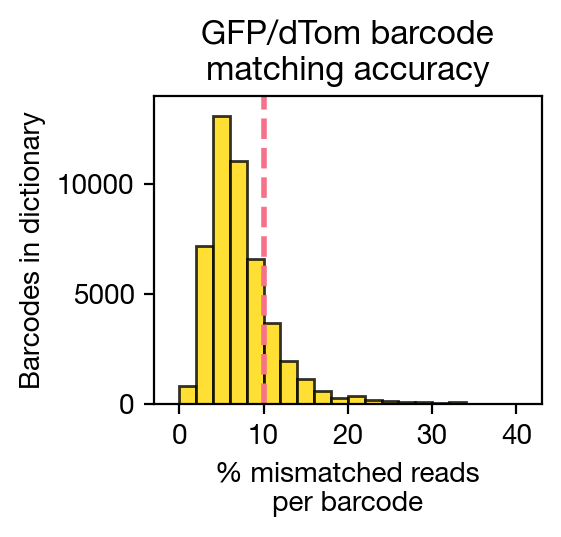

In [37]:
plt.figure(figsize=(2.5,2))

alph = 0.8
n=12
cutoff_percent = 10

plt.hist([x for x in mm_percents if x>1], bins=np.arange(0,100,2),
        alpha=alph, edgecolor='k', facecolor='gold',#sns.color_palette("husl", n)[1],
        label='no mismatched reads')
#plt.hist([x for x in mm_percents if (x>1)&(x<cutoff_percent)], bins=np.arange(0,100,2),
#        alpha=alph, edgecolor='white', facecolor=sns.color_palette("husl", n)[4],
#        label=f'<={cutoff_percent}% mismatched')
#plt.hist([x for x in mm_percents if x>cutoff_percent], bins=np.arange(0,100,2),
#        alpha=alph, edgecolor='white', facecolor=sns.color_palette("husl", n)[11],
#        label=f'>{cutoff_percent}% mismatched')

plt.axvline(cutoff_percent, color=nicecolors(0), linewidth=2, linestyle='--')
#plt.annotate(f'keep: {len([(x,y) for x,y in mm_rates if x<=np.log10(cutoff_percent/100)])}', 
#             xy=(0.02, 0.95), xycoords='axes fraction', fontsize=8)
#plt.annotate(f'toss: {len([(x,y) for x,y in mm_rates if x>np.log10(cutoff_percent/100)])}', 
#             xy=(0.31, 0.95), xycoords='axes fraction', fontsize=8)

plt.xlabel('% mismatched reads\nper barcode')
plt.ylabel('Barcodes in dictionary')
plt.title('GFP/dTom barcode\nmatching accuracy')
plt.xticks([0,10,20,30,40])
plt.xlim(-3,43)
plt.ylim(0,13990)
#plt.legend(fontsize=7, loc=5)

plt.savefig('figures/Fig2D.png', dpi=900, bbox_inches='tight')

plt.show()

In [156]:
# manually removing a barcode that I suspect is a carried over cloning intermediate

#bcs_to_keep = [(x,y) for x,y in mm_rates if (x<=np.log10(cutoff_percent/100))&(y!='TCAACCTCAACATAACTT')]
bcs_to_keep = [(x,y) for x,y in mm_rates if (x<=np.log10(cutoff_percent/100))]
#with (open(outpath+'pkls/06_4_barcodes_with_less_than_10_percent_reads_mismatched_v2_min3readclusters.pkl','wb')) as f:
with (open(outpath+'pkls/06_4_barcodes_with_less_than_10_percent_reads_mismatched_v3_min3readclusters.pkl','wb')) as f:
    pickle.dump(bcs_to_keep,f)

#bcs_to_toss = [(x,y) for x,y in mm_rates if x>np.log10(cutoff_percent/100)]
#with (open(outpath+'pkls/06_4_barcodes_with_more_than_10_percent_reads_mismatched_v2_min3readclusters.pkl','wb')) as f:
#    pickle.dump(bcs_to_toss,f)

In [157]:
len(bcs_to_keep)

38158

In [158]:
len(bcs_to_keep)/len(b2i)

0.7671337528397097

In [172]:
len(b2i)

49741

In [159]:
# what is the distribution of lev dists 
# between barcodes for barcodes with mismatch rates between 85 and 90???
# if it is centered around 12 probably totally different...
# individual barcodes where the mismatch numbers are 4>5>6 are probably seq errors...
# maybe take the mean lev dist per barcode rather than counting above/below some threshold?

bcs_to_check = [(x,y) for x,y in mm_rates if (x>=np.log10(0.1))&(x<=np.log10(0.15))]
len(bcs_to_check)

7664

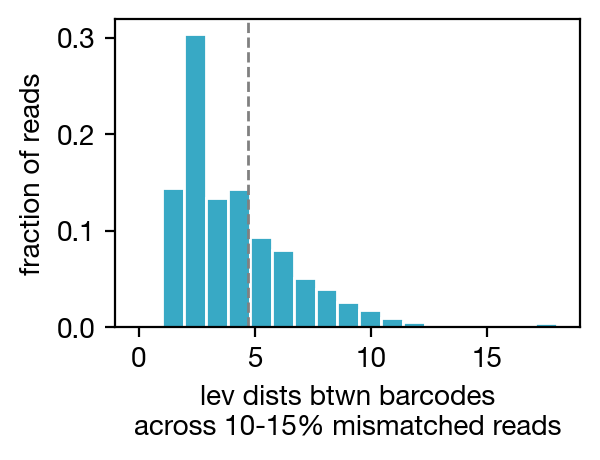

In [160]:
dists_to_check = flatten([bc_distance_counts[bc] for mmr, bc in bcs_to_check])

plt.figure(figsize=(3,2))
plt.hist([x for x in dists_to_check if x>0], density=True,
        bins=18, facecolor=nicecolors(3), edgecolor='w')
plt.ylabel('fraction of reads')
plt.xlabel('lev dists btwn barcodes\nacross 10-15% mismatched reads')
plt.axvline(4.7, color='grey', linewidth=1, linestyle='--')
plt.xlim(-1,19)
plt.show()

In [18]:
# are the qPCR-validated ints in the final dictionary?

# load in barcode-to-intron dictionary
#with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'rb') as f:
#    b2i = pickle.load(f)

with open('/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/random_int_qPCR_IME_barcodes_2023.pkl','rb') as f:
    qPCR_barcodes = pickle.load(f)

samples2compare = ['pEK24','pEK26','pEK28','pEK29','pEK30','pEK31','pEK32',
                   'pEK33','pEK34','pEK35','pEK36','pEK37','pEK38',
                  'RI10','RI13','RI19']
samplenames2compare = ['intronless','UbC','intron 1', 'intron 2', 'intron 3', 'intron 4', 'intron 5',
                   'intron F1', 'intron F2', 'intron F3', 'intron F4', 'intron F5', 'intron F6',
                      "RI10",'RI13','RI19']

In [19]:
qPCR_barcodes

{'pEK28': ['TAACACCCACTCTCCCAC',
  'TAACACCCACTCTCACAC',
  'TAACACCCACTCTCATAC',
  'TAACACCCACACTCACAC',
  'AAACCCCCCACAACACCA',
  'TAACACCCCCTCTCCCAC',
  'TAACCCCCACTCTCCCAC',
  'TAATACCCACTCTCACAC',
  'TAACACCCACTCTCACCC',
  'TAACACCCCCTCTCACCC',
  'TAACACCCCCTCTCACAC',
  'TAACCCCCACTCTCACCC',
  'TTCCTCATCATACAAACT',
  'TAACCCCCACTCTCACAC',
  'TAACCCCCCCTCTCACAC'],
 'pEK29': ['TCAACCCTATCCCCTACC',
  'TCTACCCAATCCCCTACC',
  'TCTACCCTTTCCCCTACC',
  'TCTATCCTATCCCCTACC',
  'TCTACCCTATCCCCTACC',
  'TCAACCCTATCCCCAACC',
  'TCTACCCTATCCCCTCCC',
  'TCTACCCTATACCCTACC',
  'TCTACCCTATCCCCTACT',
  'TCTAACCTATCCCCTACC',
  'TCTACCCTATCCCCAACC',
  'TATACCCTATCCCCTACC',
  'TCTACCCTAACCCCTACC',
  'TCTACTCTATCCCCTACC',
  'TCTACCCTATCCCCTTCC',
  'TCTTCCCTATCCCCTACC',
  'TCTACCTTATCCCCTACC',
  'TTTACCCTATCCCCTACC',
  'TCTACCCTATTCCCTACC',
  'TCTACCCTATCACCTACC',
  'TCTACCCTATCCTCTACC',
  'TCTACCCTATCCCCTATC',
  'TCTACCCTATCTCCTACC'],
 'pEK30': ['TCCCATCCCTATAATTTA',
  'TTCCATCCCCATAATTTA',
  'TTTCATCC

In [20]:
for intron, bcs in qPCR_barcodes.items():
    valid = [b for b in bcs if b in b2i]
    if len(valid)>0:
        print((intron, valid))
    elif len(valid)==0:
        boos = list(set(flatten([one_offs(b) for b in bcs])))
        for boo in boos:
            if boo in b2i:
                print((intron, boo))

('pEK28', ['TAACACCCACTCTCACAC'])
('pEK31', 'TCCCAACATTTCTTAATA')
('pEK33', ['CTTACCCCTATAAACTCC'])
('pEK35', ['ATACCAATTACCTTAAAT'])
('pEK38', ['CTATCCAATAATACCACA'])
('pEK24', ['ACTATCTAACCAAACACA', 'ACTCCTTCAATCCCATCA', 'CATAACTTAATTATTTTA', 'TACATTATCTCTTCATAC'])
('pEK26', ['ATACCATAACTACCCACT'])


In [24]:
2**1.5

2.8284271247461903